### load Libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
import joblib
import pickle
import pandas as pd 
import copy
import skimage.transform
from torch import topk
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
from sklearn.metrics import classification_report

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
!nvidia-smi

Sun Oct  3 09:14:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    30W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Data Preparation

In [6]:
train_imgs = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/train_imgs.npy')
train_y = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/train_y.npy')
val_imgs = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/val_imgs.npy')
val_y = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/val_y.npy')

X = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/X.npy')
y = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/y.npy')
X_test = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/X_test.npy')
y_test = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/y_test.npy')

In [7]:
y=np.array(y)
y_test=np.array(y_test)

In [8]:
train_imgs_color = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/train_imgs_color.npy')
train_y_color = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/train_y_color.npy')
val_imgs_color = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/val_imgs_color.npy')
val_y_color = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/val_y_color.npy')

X_color = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/X_color.npy')
y_color = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/y_color.npy')
X_test_color = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/X_test_color.npy')
y_test_color = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/y_test_color.npy')

In [9]:
y_color=np.array(y_color)
y_test_color=np.array(y_test_color)

In [10]:
# data transform to size 224*224
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# data transform to size 64*64
data_transforms2 = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        x = Image.fromarray(x).convert('RGB')
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

    def get_transformed(self):
      self.data2 = []
      for x in self.data:
        x = Image.fromarray(x)
        self.data2.append(self.transform(x))
      return torch.from_numpy(np.array(self.data2)).float()

# dataset 

# dataset Color
train_dataset_color = MyDataset(train_imgs_color, train_y_color, data_transforms['train'])
val_dataset_color = MyDataset(val_imgs_color,val_y_color,data_transforms['val'])
test_dataset_color = MyDataset(X_test_color,y_test_color,data_transforms['test'])

train_dataset2_color = MyDataset(train_imgs_color, train_y_color, data_transforms2['train'])
val_dataset2_color = MyDataset(val_imgs_color,val_y_color,data_transforms2['val'])
test_dataset2_color = MyDataset(X_test_color,y_test_color,data_transforms2['test'])

In [12]:
torch.manual_seed(42)
# loaders for color of size 224*224 
train_loader_color = DataLoader(train_dataset_color, batch_size=32, shuffle=True)
valid_loader_color = DataLoader(val_dataset_color, batch_size=32, shuffle=False)
test_loader_color = DataLoader(test_dataset_color, batch_size=32, shuffle=False)

# loaders for color of size 64*64
train_loader2_color = DataLoader(train_dataset2_color, batch_size=32, shuffle=True)
valid_loader2_color = DataLoader(val_dataset2_color, batch_size=32, shuffle=False)
test_loader2_color = DataLoader(test_dataset2_color, batch_size=32, shuffle=False)

### Model Testing Methods

In [13]:
def test(test_loaders, model, criterion):
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    
    model.eval()
    for batch_idx, (data, target) in enumerate(test_loaders):
        # move to GPU or CPU
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())
            
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    return y, y_hat

In [14]:
def val(test_loaders, model, criterion):
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    model.eval()
    for batch_idx, (data, target) in enumerate(test_loaders):
        # move to GPU or CPU
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss\\\\\\\\
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Val Loss: {:.6f}\n'.format(test_loss))

    print('Val Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    return y, y_hat

In [15]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [16]:
# confusion matrix code 
import itertools
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
def confusion_matrix2(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None):
        """
        cm: confusion matrix to be plotted.
        classes: array of labels or class names.
        title: title of the confusion matrix.
        cmap: color of the plot matrix.
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        
        # Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        cm = cm.astype(np.int64)
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
        if path:
            if filename is None:
                plt.savefig(os.path.join(path, title + '.png'))
            else:
                plt.savefig(os.path.join(path, filename + '.png'))
        plt.show()

### Resnet101 [ Stratergy-1 : freezing all layers parameters ] 

In [17]:
pretrained_model_1 = models.resnet101(pretrained=True)

# freezing all parameters 
for param in pretrained_model_1.parameters():
    param.requires_grad = False 

nb_features = pretrained_model_1.fc.in_features 
pretrained_model_1.to(device)

# changing last layer 
pretrained_model_1.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10),
    nn.LogSoftmax(dim=1)
)
pretrained_model_1.to(device)
pretrained_model_1.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=10, bias=True)
  (4): LogSoftmax(dim=1)
)

In [18]:
# setting optimizer 
pretrained_criterion_1 = nn.CrossEntropyLoss()
params_1 = list(pretrained_model_1.fc.parameters()) 
pretrained_optimizer_1 = torch.optim.Adam(params_1, lr=0.001)

In [19]:
# scheduler 
# Decay LR by a factor of 0.1 every 7 epochs
from torch.optim import lr_scheduler
exp_lr_scheduler_1 = lr_scheduler.StepLR(pretrained_optimizer_1, step_size=7, gamma=0.1)

In [20]:
base_model_1 = models.resnet101(pretrained=True)

# freezing all parameters 
for param in base_model_1.parameters():
    param.requires_grad = False 

# nb_features = base_model_1.fc.in_features 
# pretrained_model_1.to(device)

# changing last layer 
base_model_1.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10),
    nn.LogSoftmax(dim=1)
)
base_model_1.to(device)
# pretrained_model_1.fc

base_model_1.load_state_dict(torch.load('/content/gdrive/MyDrive/ISS-Project/Models/resnet_model_1_S1.pt'))


<All keys matched successfully>

### Resnet101 Testing#1

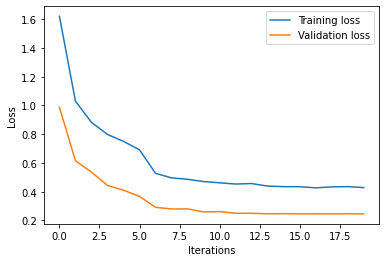

In [21]:

train_losses_res_1 = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/train_losses_res_1.npy', allow_pickle=True)
val_losses_res_1 = np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/val_losses_res_1.npy',allow_pickle=True)

plt.plot(train_losses_res_1, label='Training loss')
plt.plot(val_losses_res_1, label='Validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
_ = plt.ylim()
# plt.title('Training Validation Loss with CNN from scratch')
# plt.savefig('plots/Training Validation Loss with CNN from scratch.png')
plt.show()


In [22]:
yresval, y_hatresval = val(valid_loader_color,base_model_1 , pretrained_criterion_1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Val Loss: 0.245970

Val Accuracy: 93% (1678/1794)


In [23]:
cmresnetval1 = confusion_matrix(yresval, y_hatresval)

In [24]:
target_names = ['Safe Driving', 'Texting - Right', 'Talking on the Phone - Right','Texting - Left', 'Talking on the Phone - Left','Operating the Radio','Drinking','Reaching Behind','Hair and Makeup','Talking to Passenger']
report=classification_report(yresval, y_hatresval, target_names=target_names,output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('resnetvalreport.csv')
print(classification_report(yresval, y_hatresval, target_names=target_names)

SyntaxError: ignored

<Figure size 432x288 with 0 Axes>

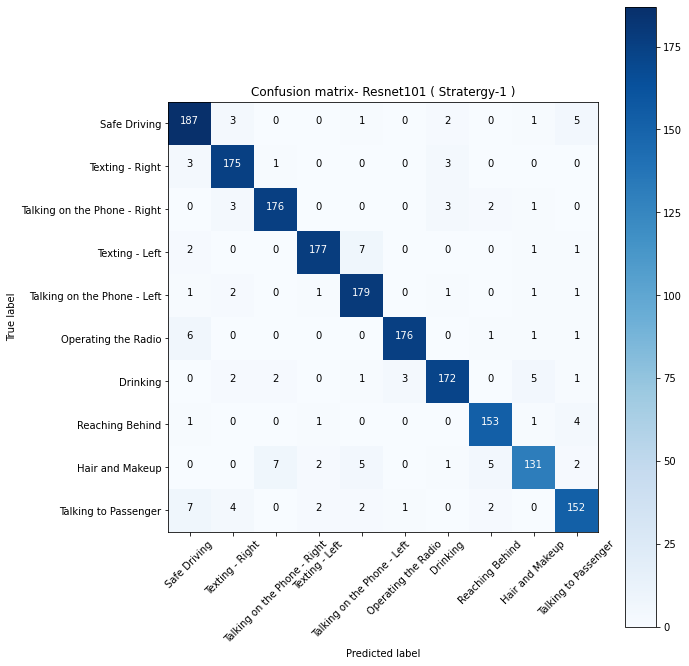

In [25]:
plt.figure()
confusion_matrix2(cmresnetval1, classes=['Safe Driving','Texting - Right','Talking on the Phone - Right','Texting - Left','Talking on the Phone - Left',
                                         'Operating the Radio','Drinking','Reaching Behind','Hair and Makeup','Talking to Passenger'],title='Confusion matrix- Resnet101 ( Stratergy-1 )',
                           filename='Confusion Matrix with Resnet101', figsize=(10,10))

In [26]:
# Testing test data set over Resnet and images 224*224 stratery1
y, y_hat = test(test_loader_color,base_model_1 , pretrained_criterion_1)

Test Loss: 0.263660


Test Accuracy: 92% (4138/4485)


In [27]:
cmresnet1 = confusion_matrix(y, y_hat)

In [28]:
target_names = ['Safe Driving', 'Texting - Right', 'Talking on the Phone - Right','Texting - Left', 'Talking on the Phone - Left','Operating the Radio','Drinking','Reaching Behind','Hair and Makeup','Talking to Passenger']
report=classification_report(y, y_hat, target_names=target_names,output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('resnettestreport.csv')

<Figure size 432x288 with 0 Axes>

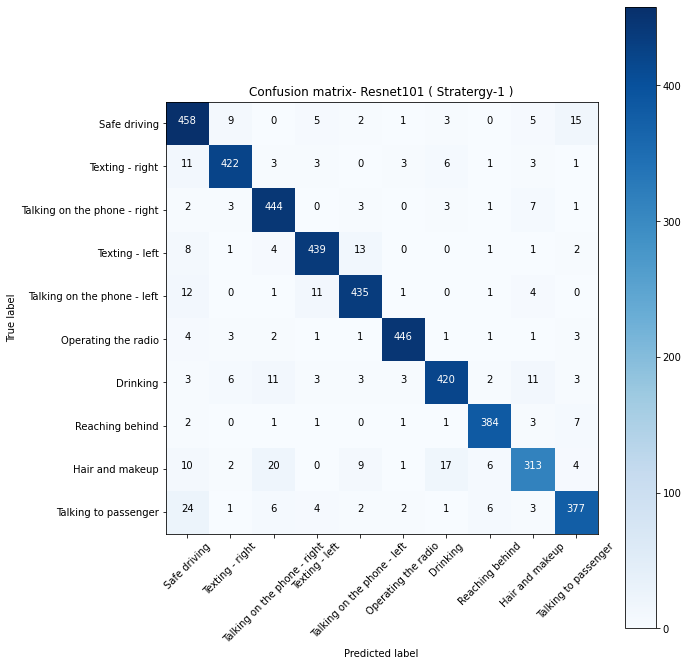

In [29]:
plt.figure()
confusion_matrix2(cmresnet1, classes=['Safe driving','Texting - right','Talking on the phone - right','Texting - left','Talking on the phone - left','Operating the radio','Drinking','Reaching behind','Hair and makeup','Talking to passenger']
                  ,title='Confusion matrix- Resnet101 ( Stratergy-1 )',
                           filename='Confusion Matrix with Resnet101', figsize=(10,10))

### Resnet101 [ Stratergy-2 : frezing previous layers and training only last few ] 

In [41]:
pretrained_model_2 = models.resnet101(pretrained=True)
# pretrained_model_2 = models.vgg16(pretrained=True)

for param in pretrained_model_2.parameters():
    param.requires_grad = False 

for param in pretrained_model_2.layer4.parameters():
    param.requires_grad = True

nb_features = pretrained_model_2.fc.in_features 

pretrained_model_2.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10),
    nn.LogSoftmax(dim=1)
)
pretrained_model_2.to(device)
pretrained_model_2.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=10, bias=True)
  (4): LogSoftmax(dim=1)
)

In [42]:
pretrained_criterion_2 = nn.CrossEntropyLoss()
params_2 = list(pretrained_model_2.fc.parameters()) + list(pretrained_model_2.layer4.parameters())
pretrained_optimizer_2 = torch.optim.Adam(params_2, lr=0.001)

In [43]:
from torch.optim import lr_scheduler
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_2 = lr_scheduler.StepLR(pretrained_optimizer_2, step_size=7, gamma=0.1)

In [44]:
base_model_2 = models.resnet101(pretrained=True)

# freezing all parameters 
for param in base_model_2.parameters():
    param.requires_grad = False 


for param in base_model_2.layer4.parameters():
    param.requires_grad = True

# nb_features = base_model_1.fc.in_features 
# pretrained_model_1.to(device)

# changing last layer 
base_model_2.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10),
    nn.LogSoftmax(dim=1)
)
base_model_2.to(device)
# pretrained_model_1.fc

base_model_2.load_state_dict(torch.load('/content/gdrive/MyDrive/ISS-Project/Models/resnet_model_2_S2.pt'))


<All keys matched successfully>

### Resnet101 Testing#2

In [45]:
yres2val, y_hatres2val = val(valid_loader_color,base_model_2 , pretrained_criterion_2)

Val Loss: 0.028690

Val Accuracy: 99% (1788/1794)


In [46]:
cmresnet2val = confusion_matrix(yres2val, y_hatres2val)

In [47]:
target_names = ['Safe driving','Texting - right','Talking on the phone - right','Texting - left','Talking on the phone - left','Operating the radio','Drinking','Reaching behind','Hair and makeup','Talking to passenger']
report=classification_report(yres2val, y_hatres2val, target_names=target_names,output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('resnet2valreport.csv')
print(classification_report(yres2val, y_hatres2val, target_names=target_names))

                              precision    recall  f1-score   support

                Safe driving       1.00      1.00      1.00       199
             Texting - right       1.00      1.00      1.00       182
Talking on the phone - right       1.00      1.00      1.00       185
              Texting - left       1.00      0.99      1.00       188
 Talking on the phone - left       1.00      1.00      1.00       186
         Operating the radio       0.99      1.00      1.00       185
                    Drinking       0.99      1.00      1.00       186
             Reaching behind       0.98      1.00      0.99       160
             Hair and makeup       0.99      0.99      0.99       153
        Talking to passenger       1.00      0.98      0.99       170

                    accuracy                           1.00      1794
                   macro avg       1.00      1.00      1.00      1794
                weighted avg       1.00      1.00      1.00      1794



<Figure size 432x288 with 0 Axes>

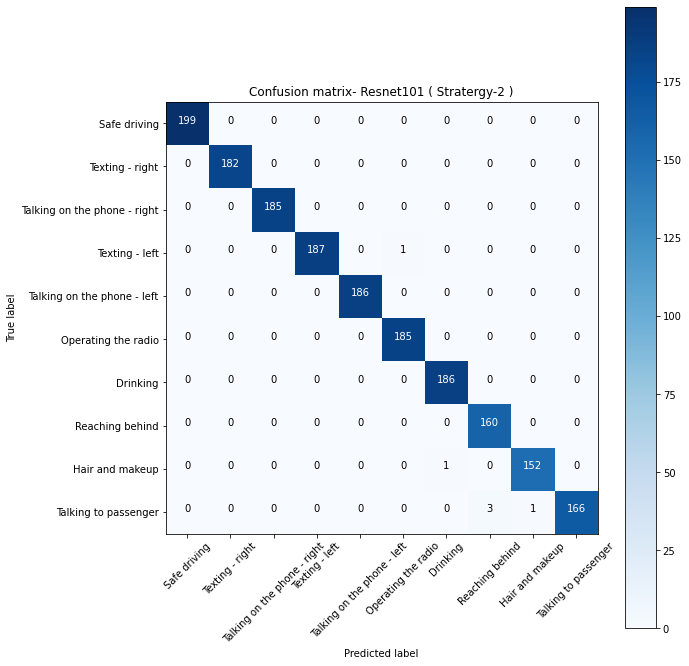

In [49]:
plt.figure()
confusion_matrix2(cmresnet2val, classes=['Safe driving','Texting - right','Talking on the phone - right','Texting - left','Talking on the phone - left','Operating the radio',
                                         'Drinking','Reaching behind','Hair and makeup','Talking to passenger'],title='Confusion matrix- Resnet101 ( Stratergy-2 )',
                           filename='Confusion Matrix with CNN from scratch', figsize=(10,10))

In [50]:
# Testing test data set over Resnet and images 224*224 stratery2 
y, y_hat = test(test_loader_color,base_model_2 , pretrained_criterion_2)

Test Loss: 0.016978


Test Accuracy: 99% (4471/4485)


In [51]:
cmresnet2 = confusion_matrix(y, y_hat)

In [52]:
target_names =['Safe driving','Texting - right','Talking on the phone - right','Texting - left','Talking on the phone - left','Operating the radio','Drinking','Reaching behind','Hair and makeup','Talking to passenger']
report=classification_report(y, y_hat, target_names=target_names,output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('resnet2testreport.csv')
print(classification_report(y, y_hat, target_names=target_names))

                              precision    recall  f1-score   support

                Safe driving       0.99      1.00      0.99       498
             Texting - right       0.99      1.00      1.00       453
Talking on the phone - right       1.00      1.00      1.00       464
              Texting - left       1.00      1.00      1.00       469
 Talking on the phone - left       1.00      1.00      1.00       465
         Operating the radio       1.00      0.99      0.99       463
                    Drinking       1.00      1.00      1.00       465
             Reaching behind       1.00      1.00      1.00       400
             Hair and makeup       0.99      0.99      0.99       382
        Talking to passenger       1.00      0.99      1.00       426

                    accuracy                           1.00      4485
                   macro avg       1.00      1.00      1.00      4485
                weighted avg       1.00      1.00      1.00      4485



<Figure size 432x288 with 0 Axes>

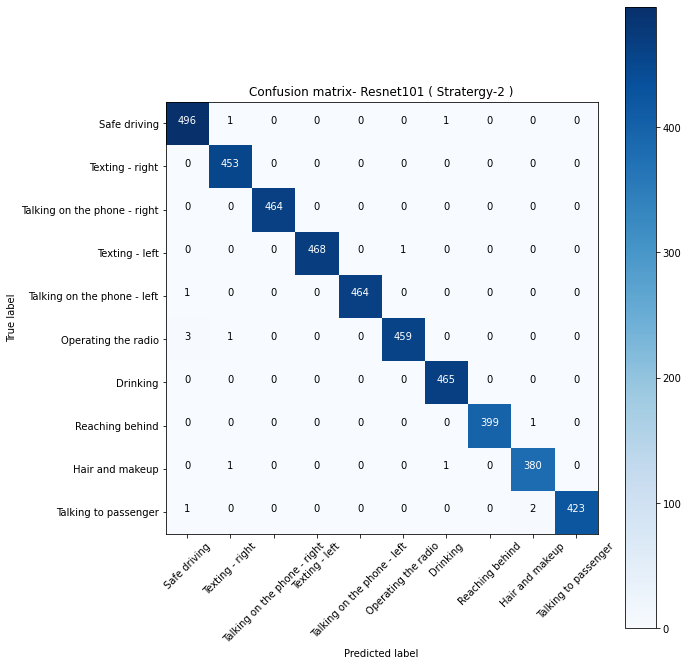

In [53]:
plt.figure()
confusion_matrix2(cmresnet2, classes=['Safe driving','Texting - right','Talking on the phone - right','Texting - left','Talking on the phone - left','Operating the radio','Drinking','Reaching behind','Hair and makeup','Talking to passenger']
,title='Confusion matrix- Resnet101 ( Stratergy-2 )',
                           filename='Confusion Matrix with CNN from scratch', figsize=(10,10))

### Class Activation Map over resnet 

In [54]:
def display_class_activation_mapping(img , base_model, ax=None):

  class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

  def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

  # CODE TO PREPROCESS IMAGE   
  normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
  )

  # Preprocessing - scale to 224x224 for model, convert to tensor, 
  # and normalize to -1..1 with mean/std for ImageNet

  preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
  ])

  display_transform = transforms.Compose([
    transforms.Resize((224,224))])

  img = Image.fromarray(img).convert('RGB')
  tensor = preprocess(img)
  prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)
  plt.imshow(img)

  # PREDICTION USING MODEL  
  base_model.cuda()
  base_model.eval()


  # save features of final layer 
  final_layer = base_model._modules.get('layer4')

  activated_features = SaveFeatures(final_layer)

  prediction = base_model(prediction_var)

  activated_features.remove()

  weight_softmax_params = list(base_model._modules.get('fc').parameters())
  weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

  # predicted class 
  class_idx = topk(prediction,1)[1].int()
  arr = ['safe driving', 'Texting right hand','Talking on the phone using right hand' , 'Texting using left hand' , 'Talking on the phone using left hand' , 'Operating (Adjusting) the radio', 'Drinking' , 'Reaching behind' , 'Hair and makep' , 'Talking to passenger']
  # print(arr[class_idx])
  
  overlay = getCAM(activated_features.features, weight_softmax, class_idx )

  display_transform = transforms.Compose([
    transforms.Resize((224,224))])

  if ax is None:
    plt.imshow(display_transform(img))
    plt.imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');
  else:
    ax.imshow(display_transform(img))
    ax.imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

  return arr[class_idx]



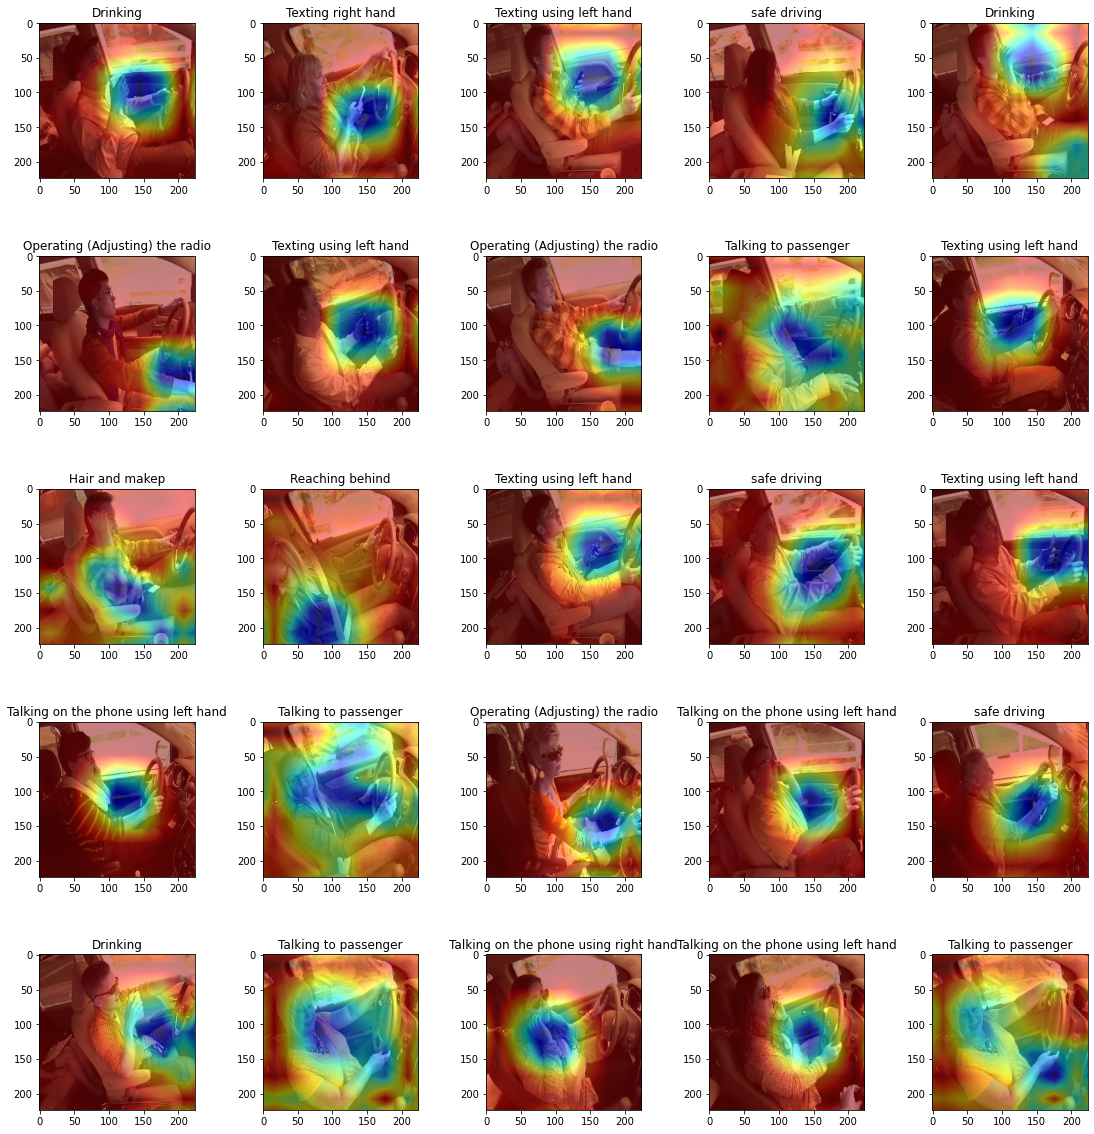

In [55]:
# Displaying some train images 
temp = [20,200,300,400,700,150,900,1000,110,950,10,500,600,350,765,733,699,777,11,244,632,33,93,40,76]
fig, axs = plt.subplots(5,5, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
j = 0
for i, ax in enumerate(axs.ravel()):
  t = display_class_activation_mapping(val_imgs_color[temp[j]] , base_model_2,ax)
  ax.title.set_text(t)
  j = j+1 

### Visualization on results by resnet - Stratergy 2 

In [56]:
dataloaders = {}
dataloaders['train'] = train_loader_color
dataloaders['val'] = valid_loader_color 
dataloaders['test'] = test_loader_color 
dataset_sizes = {}
dataset_sizes['train'] = np.shape(train_imgs)[0]
dataset_sizes['val'] = np.shape(val_imgs)[0]
dataset_sizes['test'] = np.shape(X_test_color)[0]

In [57]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

def temp_imshow(inp, title=None):
    # # plt.figure(figsize=(6, 5))
    # inp = inp.numpy().transpose((1, 2, 0))
    # plt.imshow(inp.astype('uint8'))
    # if title is not None:
    #     plt.title(title)
    # plt.pause(0.001)  # Pause a bit so that plots are updated

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(6, 6))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated



In [58]:
def visualize_model(model, num_images=20):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                # print(int(preds[j].item()))
                ax.set_title('predicted: {}'.format(class_names[int(preds[j].item())]))
                temp_imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [59]:
arr = ['safe driving', 'Texting right hand','Talking on the phone using right hand' , 'Texting using left hand' , 'Talking on the phone using left hand' , 'Operating (Adjusting) the radio', 'Drinking' , 'Reaching behind' , 'Hair and makep' , 'Talking to passenger']
class_names = {x : arr[x] for x in [0,1,2,3,4,5,6,7,8,9]}
visualize_model(base_model_2)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### CNN using Color Image

In [10]:
import numpy as np # linear algebra
import pickle
import datetime
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import Sequential, Input
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D,ZeroPadding2D,Conv2D
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.utils import utils
from tensorflow.keras.models import model_from_json
# from sklearn.metrics import log_loss
from numpy.random import permutation
import sklearn.metrics as metrics
import keras
import keras.backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Add, Input, BatchNormalization, Activation
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
import cv2
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
import torch.nn as nn
%matplotlib inline
# Any results you write to the current directory are saved as output.

In [11]:
def CreateModel(img_rows,img_cols,channels):
  model = Sequential()
  model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(img_rows,img_cols,channels)))
  model.add(BatchNormalization())
  model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization(axis = 3))
  model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
  model.add(Dropout(0.3))
  model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization(axis = 3))
  model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
  model.add(Dropout(0.3))
  model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization(axis = 3))
  model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(units = 512,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(units = 128,activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(10,activation='softmax'))
  model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
  return model

In [12]:
modelGo=CreateModel(224,224,3)

In [13]:
#folderpath      = '/content/gdrive/My Drive/iss/rtavs/colab/'
filepath        = '/content/gdrive/MyDrive/ISS-Project/Models/modifiedvg316.hdf5'
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [28]:
y_hat_valcolor=modelGo.predict(val_imgs_color)

In [29]:
y_hat_valcolor=np.argmax(y_hat_valcolor,axis=1)

In [30]:
metrics.accuracy_score(val_y_color, y_hat_valcolor)

0.9988851727982163

In [31]:
cmcnnvalcolor = confusion_matrix(val_y_color, y_hat_valcolor)

In [32]:
target_names =['Safe driving','Texting - right','Talking on the phone - right','Texting - left','Talking on the phone - left','Operating the radio','Drinking','Reaching behind','Hair and makeup','Talking to passenger']
report=classification_report(val_y_color, y_hat_valcolor, target_names=target_names,output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('vggvalreport.csv')

print(classification_report(val_y_color, y_hat_valcolor, target_names=target_names))

                              precision    recall  f1-score   support

                Safe driving       1.00      1.00      1.00       199
             Texting - right       1.00      1.00      1.00       182
Talking on the phone - right       1.00      1.00      1.00       185
              Texting - left       1.00      1.00      1.00       188
 Talking on the phone - left       1.00      1.00      1.00       186
         Operating the radio       1.00      1.00      1.00       185
                    Drinking       0.99      1.00      1.00       186
             Reaching behind       1.00      1.00      1.00       160
             Hair and makeup       0.99      0.99      0.99       153
        Talking to passenger       1.00      0.99      1.00       170

                    accuracy                           1.00      1794
                   macro avg       1.00      1.00      1.00      1794
                weighted avg       1.00      1.00      1.00      1794



<Figure size 432x288 with 0 Axes>

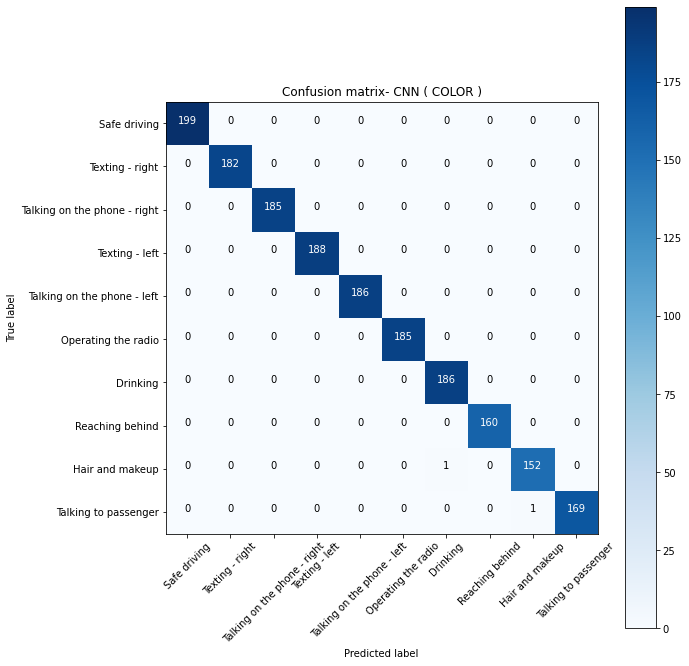

In [33]:
plt.figure()
confusion_matrix2(cmcnnvalcolor, classes=['Safe driving','Texting - right','Talking on the phone - right','Texting - left','Talking on the phone - left','Operating the radio','Drinking','Reaching behind','Hair and makeup','Talking to passenger']
,title='Confusion matrix- CNN ( COLOR )',
                           filename='Confusion Matrix with CNN from scratch with Gray Images', figsize=(10,10))

In [14]:
y_hat_color=modelGo.predict(X_test_color)

In [15]:
y_hat_color=np.argmax(y_hat_color,axis=1)

In [16]:
metrics.accuracy_score(y_test_color, y_hat_color)

0.9977703455964325

In [17]:
cmcnncolor = confusion_matrix(y_test_color, y_hat_color)

In [18]:
target_names = ['Safe driving','Texting - right','Talking on the phone - right','Texting - left','Talking on the phone - left','Operating the radio','Drinking','Reaching behind','Hair and makeup','Talking to passenger']

report=classification_report(y_test_color, y_hat_color, target_names=target_names,output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('vggtestreport.csv')

print(classification_report(y_test_color, y_hat_color, target_names=target_names))

                              precision    recall  f1-score   support

                Safe driving       1.00      1.00      1.00       498
             Texting - right       1.00      1.00      1.00       453
Talking on the phone - right       1.00      1.00      1.00       464
              Texting - left       1.00      1.00      1.00       469
 Talking on the phone - left       1.00      1.00      1.00       465
         Operating the radio       1.00      1.00      1.00       463
                    Drinking       1.00      1.00      1.00       465
             Reaching behind       1.00      0.99      1.00       400
             Hair and makeup       0.99      1.00      0.99       382
        Talking to passenger       1.00      1.00      1.00       426

                    accuracy                           1.00      4485
                   macro avg       1.00      1.00      1.00      4485
                weighted avg       1.00      1.00      1.00      4485



<Figure size 432x288 with 0 Axes>

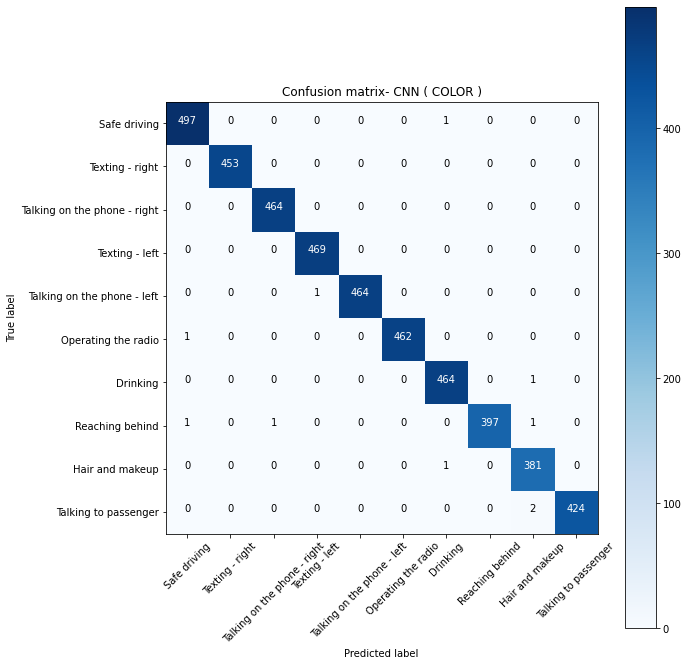

In [22]:
plt.figure()
confusion_matrix2(cmcnncolor, classes=['Safe driving','Texting - right','Talking on the phone - right','Texting - left','Talking on the phone - left','Operating the radio','Drinking','Reaching behind','Hair and makeup','Talking to passenger']
,title='Confusion matrix- CNN ( COLOR )',
                           filename='Confusion Matrix with CNN from scratch with Gray Images', figsize=(10,10))

### CNN Using Gray

In [ ]:
XG=np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/img_loads_resize_gray.npy')

In [ ]:
img_labels=np.load('/content/gdrive/MyDrive/ISS-Project/NumpyArrays/img_labels.npy')

In [ ]:
y_clss=[]
mapping = {'c0' : 0, 'c1' :1, 'c2':2, 'c3':3, 'c4':4,'c5':5,'c6':6,'c7':7,'c8':8,'c9':9}
for val in img_labels:
  y_clss.append(mapping[val])

In [ ]:
full_y=y_clss

In [ ]:
X , X_test , y ,y_test = train_test_split(XG , full_y , test_size=0.2, random_state=0,stratify = full_y)

In [ ]:
y=np.array(y)
y_test=np.array(y_test)

In [ ]:
X.shape  , X_test.shape , y.shape ,y_test.shape 

((17939, 224, 224, 1), (4485, 224, 224, 1), (17939,), (4485,))

In [ ]:
train_imgs , val_imgs , train_y , val_y = train_test_split( X, y ,test_size=0.1, random_state=0,stratify = y) 

In [ ]:
train_y=np.array(train_y)
val_y=np.array(val_y)

In [ ]:
train_imgs.shape,val_imgs.shape,train_y.shape,val_y.shape

((16145, 224, 224, 1), (1794, 224, 224, 1), (16145,), (1794,))

In [ ]:
modelGray=CreateModel(224,224,1)

In [ ]:
filepath        = '/content/gdrive/MyDrive/ISS-Project/Models/modifiedvg16.hdf5'
modelGray.load_weights(filepath)
modelGray.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
y_hat_val_gray=modelGray.predict(val_imgs)

In [ ]:
y_hat_val_gray=np.argmax(y_hat_val_gray,axis=1)

In [ ]:
metrics.accuracy_score(val_y, y_hat_val_gray)

0.9994425863991081

In [ ]:
cmcnngray = confusion_matrix(val_y, y_hat_val_gray)

In [ ]:
target_names = ['0', '1', '2','3', '4','5','6','7','8','9']
print(classification_report(val_y, y_hat_val_gray, target_names=target_names))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       199
           1       1.00      1.00      1.00       182
           2       1.00      1.00      1.00       185
           3       1.00      1.00      1.00       188
           4       1.00      0.99      1.00       186
           5       1.00      1.00      1.00       185
           6       1.00      1.00      1.00       186
           7       1.00      1.00      1.00       160
           8       1.00      1.00      1.00       153
           9       1.00      1.00      1.00       170

    accuracy                           1.00      1794
   macro avg       1.00      1.00      1.00      1794
weighted avg       1.00      1.00      1.00      1794



<Figure size 432x288 with 0 Axes>

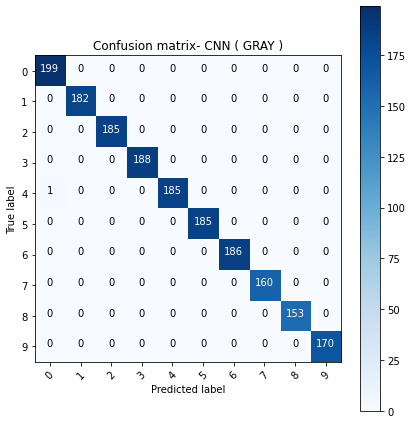

In [ ]:
plt.figure()
confusion_matrix2(cmcnngray, classes=['0','1','2','3','4','5','6','7','8','9'],title='Confusion matrix- CNN ( GRAY )',
                           filename='Confusion Matrix with CNN from scratch with Gray Images', figsize=(6,6))

In [ ]:
y_hat=modelGray.predict(X_test)

In [ ]:
y_hat=np.argmax(y_hat,axis=1)

In [ ]:
metrics.accuracy_score(y_test, y_hat)

0.9995540691192865

In [ ]:
cmcnngray2 = confusion_matrix(y_test, y_hat)

In [ ]:
target_names = ['0', '1', '2','3', '4','5','6','7','8','9']
print(classification_report(y_test, y_hat, target_names=target_names))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       498
           1       1.00      1.00      1.00       453
           2       1.00      1.00      1.00       464
           3       1.00      1.00      1.00       469
           4       1.00      1.00      1.00       465
           5       1.00      1.00      1.00       463
           6       1.00      1.00      1.00       465
           7       1.00      1.00      1.00       400
           8       1.00      1.00      1.00       382
           9       1.00      1.00      1.00       426

    accuracy                           1.00      4485
   macro avg       1.00      1.00      1.00      4485
weighted avg       1.00      1.00      1.00      4485



<Figure size 432x288 with 0 Axes>

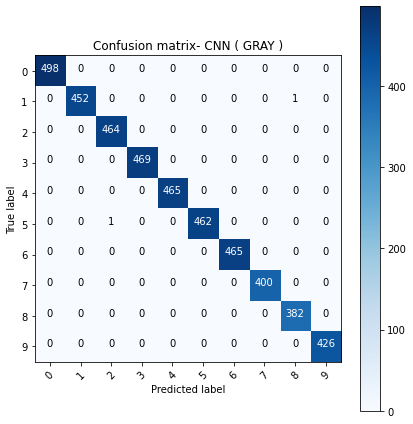

In [ ]:
plt.figure()
confusion_matrix2(cmcnngray2, classes=['0','1','2','3','4','5','6','7','8','9'],title='Confusion matrix- CNN ( GRAY )',
                           filename='Confusion Matrix with CNN from scratch with Gray Images', figsize=(6,6))

## ROC

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn import metrics
def roc(test_y, prob):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    y = label_binarize(test_y, classes=class_labels)
    n_classes = y.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y[:, i], prob[:, i])
        roc_auc[i] = metrics.roc_auc_score(y[:, i], prob[:, i])

    # Compute micro-average ROC curve and ROC area
    fpr["avg"], tpr["avg"], _ = metrics.roc_curve(y.ravel(), prob.ravel())
    roc_auc["avg"] = metrics.auc(fpr["avg"], tpr["avg"])

    return fpr, tpr, roc_auc

In [ ]:
prob1 = modelGray.predict(X_test)
fpr1, tpr1, auc_roc1 = roc(y_test, prob1)

In [ ]:
prob1.shape,y_test.shape

((4485, 10), (4485,))

In [ ]:
prob1

array([[1.08321331e-07, 6.90081605e-14, 1.44181878e-09, ...,
        3.41917765e-13, 5.40057732e-09, 3.99483133e-06],
       [3.80241127e-09, 2.34757320e-15, 4.32055693e-12, ...,
        7.19031822e-13, 5.65372239e-13, 1.05815443e-11],
       [1.30585605e-08, 1.55982314e-15, 5.63892577e-09, ...,
        7.89252171e-12, 4.25016715e-08, 1.00000000e+00],
       ...,
       [5.52793755e-10, 3.32580047e-10, 1.00000000e+00, ...,
        7.41115003e-10, 1.73324766e-12, 3.78815902e-12],
       [2.46529359e-12, 8.67701852e-13, 8.90774542e-13, ...,
        1.00000000e+00, 7.08901438e-10, 2.70435174e-10],
       [1.62347691e-10, 3.85443413e-11, 4.72948347e-11, ...,
        1.46223408e-10, 3.63733008e-08, 1.00000000e+00]], dtype=float32)

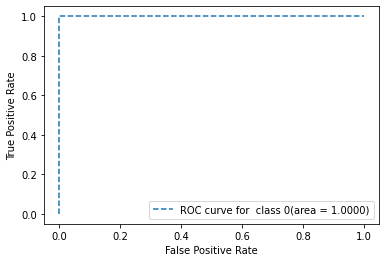

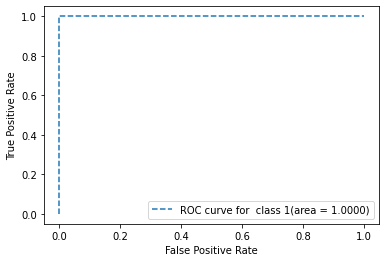

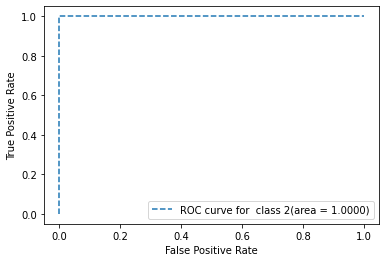

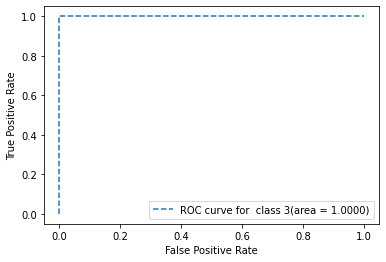

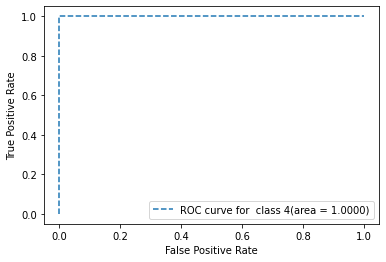

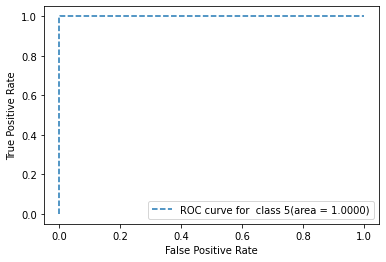

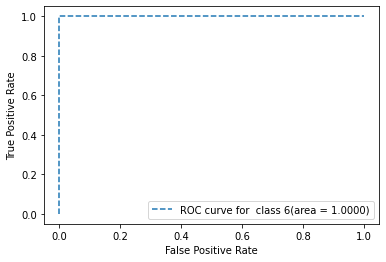

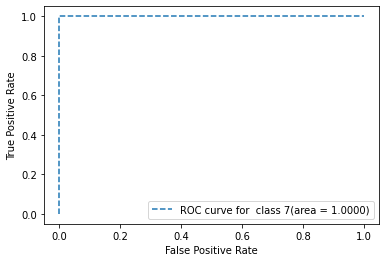

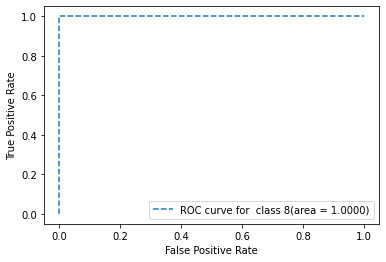

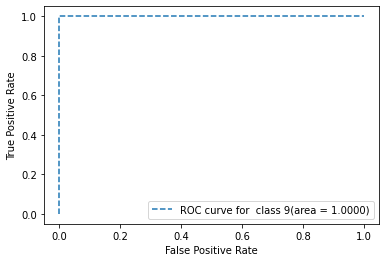

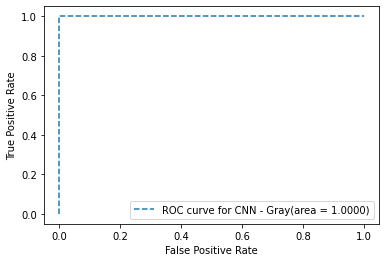

In [ ]:
class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
name_arr = ['CNN - Gray']
for i in range(10):
  plt.plot(fpr1[i],tpr1[i],linestyle='--',label='ROC curve for  class '+str(class_labels[i]) +  '(area = {:.4f})'
                ''.format(auc_roc1[i]))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

plt.plot(fpr1["avg"], tpr1["avg"], linestyle='--',label='ROC curve for ' + str(name_arr[0]) + '(area = {:.4f})'
                                                                              ''.format(auc_roc1["avg"]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
prob1 = modelGo.predict(X_test_color)
fpr1, tpr1, auc_roc1 = roc(y_test, prob1)

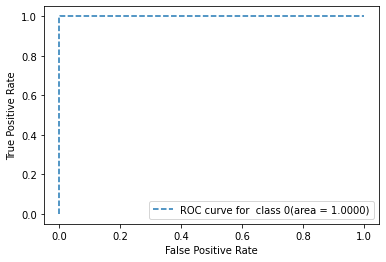

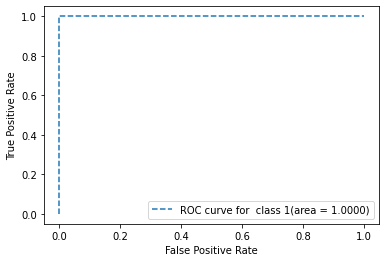

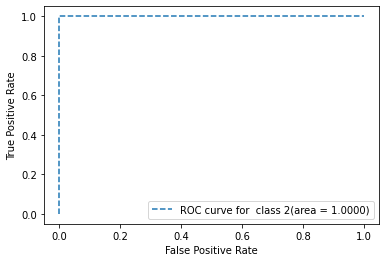

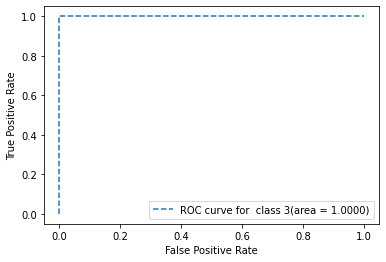

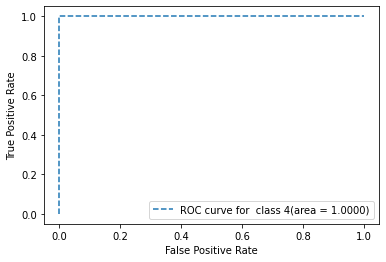

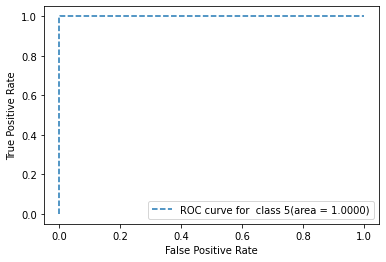

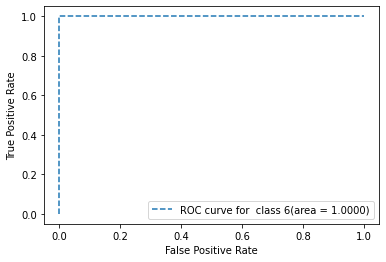

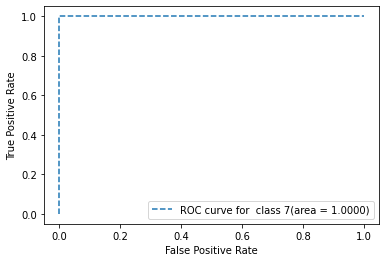

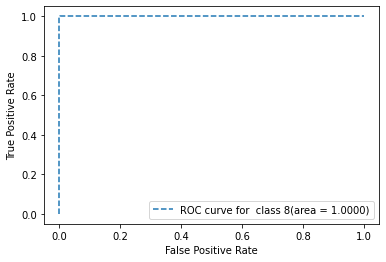

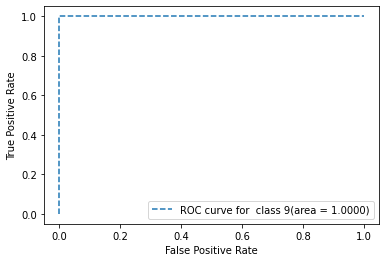

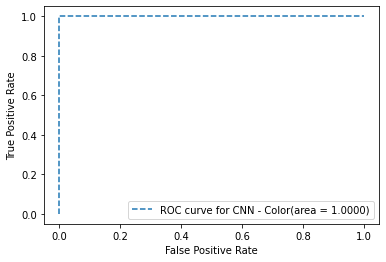

In [ ]:
class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
name_arr = ['CNN - Color']
for i in range(10):
  plt.plot(fpr1[i],tpr1[i],linestyle='--',label='ROC curve for  class '+str(class_labels[i]) +  '(area = {:.4f})'
                ''.format(auc_roc1[i]))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

plt.plot(fpr1["avg"], tpr1["avg"],linestyle='--', label='ROC curve for ' + str(name_arr[0]) + '(area = {:.4f})'
                                                                              ''.format(auc_roc1["avg"]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()